In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

data/kaggle_emotion.zip
data/val.txt
data/train.txt
data/test.txt


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm.notebook import tqdm, trange, tnrange
import random
import os
import io
%matplotlib inline

In [3]:
# identify and specify the GPU as the device, later in training loop we will load data into device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [4]:
device = torch.device("cuda")

BertTokenizer to run end-to-end tokenization: punctuation splitting + word piece. 
BertForSequenceClassification is the Bert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output). 
BertConfig is the configuration class to store model configurations. 
AdamW implements Adam learning rate optimization algorithm, it is a type of Stochastic Gradient Descent with momentum. Here momentum is described as the moving average of the gradient instead of gradient itself.
get_linear_schedule_with_warmup creates a schedule with a learning rate that decreases linearly after linearly increasing during a warm-up period.

In [5]:
df_train = pd.read_csv("data/train.txt", delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv("data/test.txt", delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv("data/val.txt", delimiter=';', header=None, names=['sentence','label'])

In [6]:
df = pd.concat([df_train,df_test,df_val])

In [7]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [8]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['label'])

In [9]:
df[['label','label_enc']].drop_duplicates(keep='first')

,label,label_enc
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [10]:
df.rename(columns={'label':'label_desc'},inplace=True)
df.rename(columns={'label_enc':'label'},inplace=True)

In [11]:
## create label and sentence list
sentences = df.sentence.values

#check distribution of data based on labels
print("Distribution of data based on labels: ",df.label.value_counts())

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,truncation=True,pad_to_max_length=True) for sent in sentences]
labels = df.label.values

print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])

## Create attention mask
attention_masks = []
## Create a mask of 1 for all input tokens and 0 for all padding tokens
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

Distribution of data based on labels:  2    6761
4    5797
0    2709
1    2373
3    1641
5     719
Name: label, dtype: int64
Actual sentence before tokenization:  im grabbing a minute to post i feel greedy wrong
Encoded Input from dataset:  [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Dataset Prep for training

#### Split into a training set and a test set using a stratified k fold

In [12]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [13]:
# convert all our data into torch tensors, required data type for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

### Lets see whats there in traindata set 

In [14]:
train_data[0]

(tensor([ 101, 1045, 2123, 1056, 2514, 2061, 9069, 2035, 1996, 2051,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [15]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [16]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6).to(device)

# Parameters:
lr = 2e-5
adam_epsilon = 1e-8

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs

### In Transformers, optimizer and schedules are splitted and instantiated like this:
optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
## Store our loss and accuracy for plotting
train_loss_set = []
learning_rate = []

# Gradients gets accumulated by default
model.zero_grad()

# tnrange is a tqdm wrapper around the normal python range
for _ in tnrange(1,epochs+1,desc='Epoch'):
    print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
    # Calculate total loss for this epoch
    batch_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), leave=False, desc="Batch", total=len(train_dataloader)):
        # Set our model to training mode (as opposed to evaluation mode)
        model.train()

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
    
        # Backward pass
        loss.backward()
    
        # Clip the norm of the gradients to 1.0
        # Gradient clipping is not in AdamW anymore
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
        # Update parameters and take a step using the computed gradient
        optimizer.step()
    
        # Update learning rate schedule
        scheduler.step()

        # Clear the previous accumulated gradients
        optimizer.zero_grad()

        # Update tracking variables
        batch_loss += loss.item()

    # Calculate the average loss over the training data.
    avg_train_loss = batch_loss / len(train_dataloader)

    #store the current learning rate
    for param_group in optimizer.param_groups:
        print("\n\tCurrent Learning rate: ",param_group['lr'])
        learning_rate.append(param_group['lr'])

    train_loss_set.append(avg_train_loss)
    print(F'\n\tAverage Training loss: {avg_train_loss}')
    
    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits[0].to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})

        tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
        tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)

        eval_accuracy += tmp_eval_accuracy
        eval_mcc_accuracy += tmp_eval_mcc_accuracy
        nb_eval_steps += 1

    print(f'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
    print(f'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

<====================== Epoch 1 ======================>



	Current Learning rate:  1.3333333333333333e-05

	Average Training loss: 0.3439699213703473

	Validation Accuracy: 0.926

	Validation MCC Accuracy: 0.9068363144855541
<====================== Epoch 2 ======================>



	Current Learning rate:  6.666666666666667e-06

	Average Training loss: 0.11910442023807102

	Validation Accuracy: 0.933

	Validation MCC Accuracy: 0.91300996956757
<====================== Epoch 3 ======================>



	Current Learning rate:  0.0

	Average Training loss: 0.08256148972113928

	Validation Accuracy: 0.934

	Validation MCC Accuracy: 0.9150445841116206



In [18]:
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [19]:
df[['label','label_desc']].drop_duplicates(keep='first')

,label,label_desc
0,4,sadness
2,0,anger
3,3,love
6,5,surprise
7,1,fear
8,2,joy


In [30]:
## emotion labels
label2int = {
    "sadness": 4,
    "joy": 2,
    "anger": 0,
    "fear": 1,
    "surprise": 5,
    "love": 3,
}

In [21]:
df_metrics['Predicted_class'].unique()

array([5, 4, 1, 2, 0, 3])

In [22]:
df_metrics['Actual_class'].unique()

array([5, 4, 1, 2, 0, 3])

Confusion matrix, without normalization
[[3 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 2]]


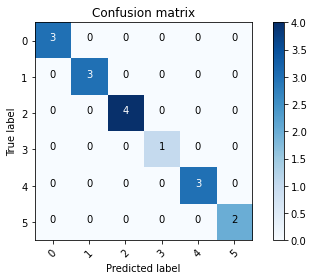

In [27]:
plot_confusion_matrix(confusion_matrix(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values), 
                      np.arange(6))

In [76]:
label2int

{'sadness': 4, 'joy': 2, 'anger': 0, 'fear': 1, 'surprise': 5, 'love': 3}

In [31]:
print(classification_report(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

     sadness   1.000000  1.000000  1.000000         3
         joy   1.000000  1.000000  1.000000         3
       anger   1.000000  1.000000  1.000000         4
        fear   1.000000  1.000000  1.000000         1
    surprise   1.000000  1.000000  1.000000         3
        love   1.000000  1.000000  1.000000         2

    accuracy                       1.000000        16
   macro avg   1.000000  1.000000  1.000000        16
weighted avg   1.000000  1.000000  1.000000        16



# Save the models for future use 

In [32]:
model_save_folder = 'classifier/'
tokenizer_save_folder = 'tokenizer/'

path_model = f'model/{model_save_folder}'
path_tokenizer = f'model/{tokenizer_save_folder}'

### Now let's save our model and tokenizer to a directory
model.save_pretrained(path_model)
tokenizer.save_pretrained(path_tokenizer)

model_save_name = 'fineTuneModel.pt'
path = path_model = f'model/{model_save_folder}/{model_save_name}'
torch.save(model.state_dict(),path);

## Test and sample

In [60]:
int2label = {v: k for k,v in label2int.items()}

In [77]:
while True:
    i = input("Input some text: ")
    if i == "q":
        break
    tokenized = tokenizer.encode(i, add_special_tokens=True,max_length=MAX_LEN,truncation=True,pad_to_max_length=True)
    tensor = torch.LongTensor(tokenized).unsqueeze(0).to(device)
    tensor_mask = torch.LongTensor([float(i>0) for i in tokenized]).unsqueeze(0).to(device)
    outputs = model(tensor, token_type_ids=None, attention_mask=tensor_mask)
    prediction = torch.argmax(outputs[0], 1).cpu().numpy()[0]
    print(f"The emotion is: {int2label[prediction]}")

Input some text: The cake was so good <3.
The emotion is: joy
Input some text: What is love?
The emotion is: anger
Input some text: q


## Mood Map

In [79]:
from seaborn import kdeplot
import seaborn as sns
import matplotlib.pyplot as plt

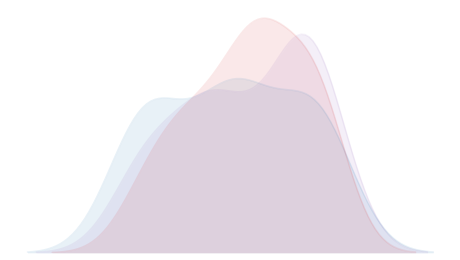

In [93]:
sns.set(style="white")
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.axis("off")
sad = np.random.random((30,))
angry = np.random.random((30,))
fear = np.random.random((30,))
kdeplot(sad / sad.max(), shade=True, color="tab:blue", ax=ax, alpha=0.1);
kdeplot(angry / angry.max(), shade=True, color="tab:red", ax=ax, alpha=0.1);
kdeplot(fear / fear.max(), shade=True, color="tab:purple", ax=ax, alpha=0.1);